In [1]:
import csv

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'hand_landmarks_end.csv'
dataset_testGood = 'hand_landmarks_goodTest.csv'
dataset_testBad = 'hand_landmarks_badTest.csv'
dataset_testDark = 'hand_landmarks_darkTest.csv'
model_save_path = 'new_hand_classifier.hdf5'
tflite_save_path = 'new_hand_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 26

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testGood = np.loadtxt(dataset_testGood, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testBad = np.loadtxt(dataset_testBad, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testDark = np.loadtxt(dataset_testDark, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
y_testGood = np.loadtxt(dataset_testGood, delimiter=',', dtype='int32', usecols=(0))
y_testBad = np.loadtxt(dataset_testBad, delimiter=',', dtype='int32', usecols=(0))
y_testDark = np.loadtxt(dataset_testDark, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)

In [7]:
print(X_train)

[[ 0.          0.         -0.125      ...  0.22443181 -0.19886364
   0.19602273]
 [ 0.          0.         -0.03215434 ... -0.16720258 -0.44694534
  -0.11575563]
 [ 0.          0.          0.11776447 ... -0.4491018  -0.16167665
  -0.4011976 ]
 ...
 [ 0.          0.         -0.1130137  ...  0.68835616  0.46575344
   0.8458904 ]
 [ 0.          0.          0.16956522 ... -0.31304348 -0.05652174
  -0.25652173]
 [ 0.          0.          0.12052117 ... -0.71335506 -0.21498372
  -0.8013029 ]]


# Model building

In [82]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Perform feature selection
selector = SelectKBest(score_func=f_classif, k='all')
X_train_selected = selector.fit_transform(X_train, y_train)
X_validation_selected = selector.transform(X_validation)

# Get feature scores
feature_scores = selector.scores_

# Get indices of selected features
selected_indices = selector.get_support(indices=True)

# Print feature scores and their corresponding indices
for i, score in enumerate(feature_scores):
    if i in selected_indices:
        print(f"Feature {i}: Score = {score}")

Feature 0: Score = nan
Feature 1: Score = nan
Feature 2: Score = 7.5963544845581055
Feature 3: Score = 1397.615966796875
Feature 4: Score = 7.034397125244141
Feature 5: Score = 2418.033935546875
Feature 6: Score = 7.134048938751221
Feature 7: Score = 3131.052490234375
Feature 8: Score = 7.852661609649658
Feature 9: Score = 3447.686767578125
Feature 10: Score = 10.174542427062988
Feature 11: Score = 915.9255981445312
Feature 12: Score = 5.5594964027404785
Feature 13: Score = 3273.6435546875
Feature 14: Score = 3.5717933177948
Feature 15: Score = 4907.64111328125
Feature 16: Score = 2.8177433013916016
Feature 17: Score = 6222.55517578125
Feature 18: Score = 11.344046592712402
Feature 19: Score = 853.8949584960938
Feature 20: Score = 4.992803573608398
Feature 21: Score = 4635.91552734375
Feature 22: Score = 3.8500454425811768
Feature 23: Score = 9194.626953125
Feature 24: Score = 2.86291766166687
Feature 25: Score = 10942.701171875
Feature 26: Score = 11.90559196472168
Feature 27: Score =

C:\gesture_recognition_by_image\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0 1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\gesture_recognition_by_image\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [83]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((21, 2, 1), input_shape=(21 * 2, )),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [84]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 21, 2, 1)          0         
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 2, 64)         256       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 10, 2, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 2, 128)        24704     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 2, 128)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 1280)             

In [85]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)

In [86]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [87]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
50/53 [===========================>..] - ETA: 0s - loss: 2.3847 - accuracy: 0.2589
Epoch 1: saving model to new_hand_classifier.hdf5
53/53 [==============================] - 2s 17ms/step - loss: 2.3361 - accuracy: 0.2738 - val_loss: 1.1454 - val_accuracy: 0.6809
Epoch 2/1000
11/53 [=====>........................] - ETA: 0s - loss: 1.2509 - accuracy: 0.5803

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - ETA: 0s - loss: 0.9043 - accuracy: 0.6978
Epoch 2: saving model to new_hand_classifier.hdf5
53/53 [==============================] - 1s 13ms/step - loss: 0.9043 - accuracy: 0.6978 - val_loss: 0.3430 - val_accuracy: 0.9243
Epoch 3/1000
49/53 [==========================>...] - ETA: 0s - loss: 0.4013 - accuracy: 0.8696
Epoch 3: saving model to new_hand_classifier.hdf5
53/53 [==============================] - 1s 12ms/step - loss: 0.3939 - accuracy: 0.8717 - val_loss: 0.1729 - val_accuracy: 0.9531
Epoch 4/1000
51/53 [===========================>..] - ETA: 0s - loss: 0.2290 - accuracy: 0.9260
Epoch 4: saving model to new_hand_classifier.hdf5
53/53 [==============================] - 1s 13ms/step - loss: 0.2275 - accuracy: 0.9262 - val_loss: 0.0937 - val_accuracy: 0.9951
Epoch 5/1000
51/53 [===========================>..] - ETA: 0s - loss: 0.1583 - accuracy: 0.9545
Epoch 5: saving model to new_hand_classifier.hdf5
53/53 [==============================] 

In [88]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testGood, y_testGood, batch_size=128)

19/19 [==============================] - 0s 4ms/step - loss: 0.2779 - accuracy: 0.9575


In [89]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testBad, y_testBad, batch_size=128)

19/19 [==============================] - 0s 4ms/step - loss: 1.3759 - accuracy: 0.7642


In [90]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testDark, y_testDark, batch_size=128)

19/19 [==============================] - 0s 4ms/step - loss: 0.9040 - accuracy: 0.9204


In [91]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [92]:
# Inference test
predict_result = model.predict(np.array([X_testGood[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 93ms/step
[1.00000000e+00 1.15523141e-26 2.81831228e-27 1.98478878e-15
 1.28553645e-28 1.03171646e-29 2.92027389e-13 2.82969499e-11
 4.35302514e-15 3.81515340e-24 1.51997182e-11 8.95757801e-10
 4.55434723e-24 1.39905597e-20 1.11155846e-14 5.85091979e-13
 1.86850161e-16 7.96059813e-24 9.55480806e-10 1.39911247e-08
 1.07988084e-23 4.16369305e-24 1.66569825e-19 2.48450484e-13
 1.25858461e-08 6.39445963e-20]
0


# Confusion matrix

75/75 [==============================] - 0s 2ms/step


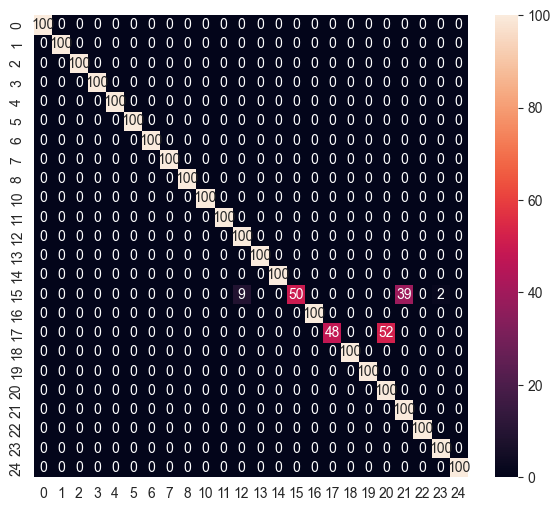

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       1.00      1.00      1.00       100
           7       1.00      1.00      1.00       100
           8       1.00      1.00      1.00       100
          10       1.00      1.00      1.00       100
          11       1.00      1.00      1.00       100
          12       0.92      1.00      0.96       100
          13       1.00      1.00      1.00       100
          14       1.00      1.00      1.00       100
          15       1.00      0.50      0.67       100
          16       1.00      1.00      1.00       100
          17       1.00      0.48      0.65       100
     

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_testGood, y_pred))

Y_pred = model.predict(X_testGood)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_testGood, y_pred)

# Convert to model for Tensorflow-Lite

In [95]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [96]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpegafqqzh\assets


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpegafqqzh\assets


380064

# Inference test

In [97]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [98]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [99]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_testGood[0]]))

In [100]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [101]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.00000000e+00 1.23521458e-26 2.48570996e-27 1.85906071e-15
 1.10245021e-28 9.50331173e-30 2.59892585e-13 2.36980210e-11
 4.28274258e-15 3.16923823e-24 1.50015035e-11 6.54483467e-10
 4.44180754e-24 1.25571405e-20 1.02526240e-14 4.80357182e-13
 1.68486593e-16 7.49491066e-24 8.08552281e-10 1.61400937e-08
 1.19767426e-23 3.80723008e-24 1.55074858e-19 2.03236272e-13
 1.08564269e-08 6.25703972e-20]
0


In [102]:
# Save the model
model.save(model_save_path, include_optimizer=False)

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Write the TFLite file
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpwgj7_5vp\assets


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpwgj7_5vp\assets


#### Loss  (cost)

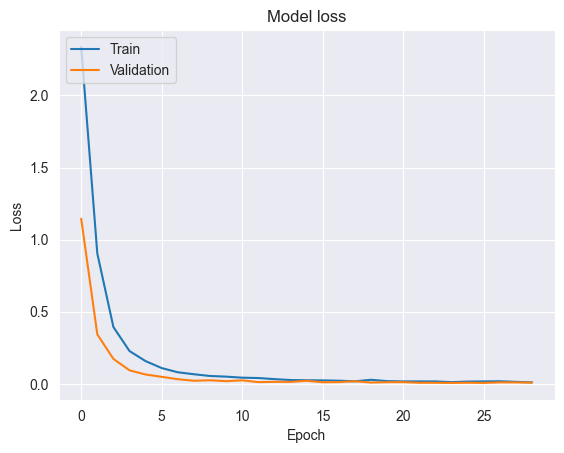

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

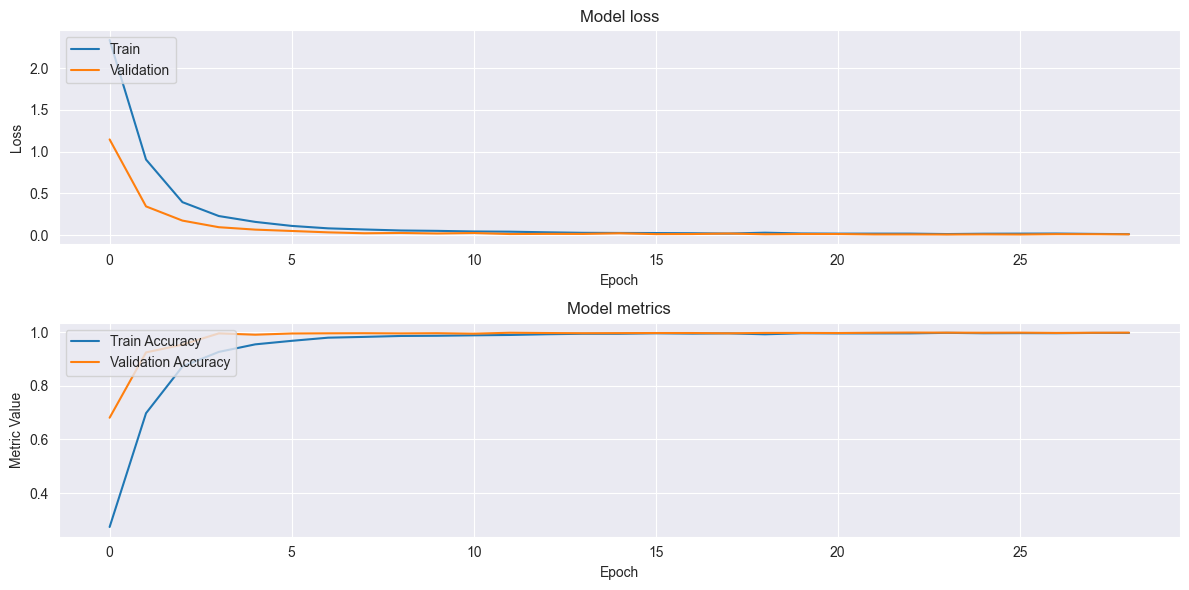

In [104]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()

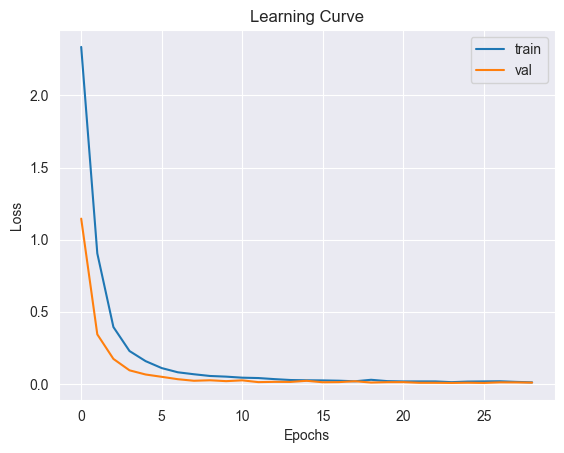

In [105]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()